In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime

import re
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE

# from bert_serving.client import BertClient

# from lightgbm import LGBMRegressor
import xgboost as xgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
# from sklear

from keras import layers, models

Using TensorFlow backend.


In [2]:
# bc = BertClient()

In [3]:
PATTERN_IDS = re.compile(r'[.,]')
PATTERN_NAMES = re.compile(r'[,]')

In [4]:
train_info = pd.read_csv('train_info.tsv', sep='\t')
test_info = pd.read_csv('test_info.tsv', sep='\t')
train_rank = pd.read_csv('train_rank.csv')

train_additional_data = pd.read_csv('train_additional_data.csv')
test_additional_data = pd.read_csv('test_additional_data.csv')

In [5]:
train_info.head()

ID                           title artist_name artist_id  \
0  1073748245          Đêm Chôn Dầu Vượt Biển   Như Quỳnh       551   
1  1073751978               Mùa Thu Trong Mưa  Minh Tuyết       455   
2  1073835561               Rồi Ánh Trăng Tan    Lưu Bích       450   
3  1073856553  Còn Thương Rau Đắng Mọc Sau Hè   Như Quỳnh       551   
4  1073929630             Người Điên Biết Yêu    Như Loan       513   

  composers_name composers_id         release_time  
0   Châu Đình An         5765  2017-10-01 22:07:00  
1      Trường Sa       100105  2017-10-01 20:58:00  
2       Quốc Bảo         4355  2017-11-01 18:16:00  
3        Bắc Sơn         7686  2017-11-01 17:36:00  
4    Lê Minh Kha       100466  2017-11-01 17:49:00

In [6]:
test_info.head()

ID                    title         artist_name  artist_id  \
0  1073994292          Giấc Mơ Mình Em          Minh Tuyết        455   
1  1074250503           Rồi 30 Năm Qua            Tâm Đoan        518   
2  1074254709         Hòa Bình Hoan Ca  Hùng Phú, Duy Linh  18241.918   
3  1074254735         Chia Tay Ngày Hè         Xuân Trường      11740   
4  1074326411  Xin Gọi Nhau Là Cố Nhân            Quang Lê        828   

  composers_name composers_id         release_time  
0        Minh Vy       100019  2017-11-01 18:27:00  
1      Nhật Ngân       100218  2017-10-01 22:07:00  
2       Huy Liêu       430572  2017-11-07 23:47:00  
3       Huy Liêu       430572  2017-11-07 23:38:00  
4      Song Ngọc       100288  2017-10-01 21:33:00

In [7]:
train_rank.head()

ID  label
0  1073748245      7
1  1073751978      3
2  1073835561      6
3  1073856553      2
4  1073929630      7

# 1. Explore data:
- ID has type int
- All other columns have type object, but artist_id and composer_id can be of type int
- There is no null values

In [8]:
## 1.1. Info data

In [9]:
train_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9078 entries, 0 to 9077
Data columns (total 7 columns):
ID                9078 non-null int64
title             9078 non-null object
artist_name       9078 non-null object
artist_id         9078 non-null object
composers_name    9078 non-null object
composers_id      9078 non-null object
release_time      9078 non-null object
dtypes: int64(1), object(6)
memory usage: 496.5+ KB


In [10]:
train_info.iloc[:, 1:].describe()

title       artist_name artist_id       composers_name  \
count               9078              9078      9078                 9078   
unique              6766              2397      2391                 2048   
top     Đắp Mộ Cuộc Tình  Hoàng Minh Thắng    601427  Nhạc Ngoại Lời Việt   
freq                  33               147       147                  178   

       composers_id         release_time  
count          9078                 9078  
unique         2212                 3675  
top          100103  2018-11-14 21:38:00  
freq            178                   26

In [11]:
# check if ID column contains all unique value
assert len(train_info.ID.unique()) == len(train_info)

In [12]:
test_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118 entries, 0 to 1117
Data columns (total 7 columns):
ID                1118 non-null int64
title             1118 non-null object
artist_name       1118 non-null object
artist_id         1118 non-null object
composers_name    1118 non-null object
composers_id      1118 non-null object
release_time      1118 non-null object
dtypes: int64(1), object(6)
memory usage: 61.2+ KB


In [13]:
test_info.iloc[:, 1:].describe()

title       artist_name artist_id       composers_name  \
count                 1118              1118      1118                 1118   
unique                1036               677       675                  587   
top     Câu Chuyện Đầu Năm  Hoàng Minh Thắng    601427  Nhạc Ngoại Lời Việt   
freq                     5                20        20                   28   

       composers_id         release_time  
count          1118                 1118  
unique          614                  860  
top          100103  2017-10-01 22:20:00  
freq             28                    6

In [14]:
assert len(test_info.ID.unique()) == len(test_info)

In [15]:
# for i in range(1, 11):
#     train_info_rank[train_info_rank.label==i].to_csv('extracted_data/train_info_rank_'+str(i)+'.csv', index=False)

## 1.2. Rank data:

In [16]:
train_rank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9078 entries, 0 to 9077
Data columns (total 2 columns):
ID       9078 non-null int64
label    9078 non-null int64
dtypes: int64(2)
memory usage: 141.9 KB


In [17]:
# check if train rank id column is the same as that of train_info
assert (train_rank.ID.sort_values() - train_info.ID.sort_values()).sum() == 0

- So it is true that 2 dataframes' ID columns are the same

In [18]:
train_rank.label.value_counts()

10    932
6     920
1     916
7     913
3     910
9     909
2     905
8     902
4     895
5     876
Name: label, dtype: int64

- Pretty good, there is no large imbalance in distribution of the label class

In [19]:
## 2.3. Go into detail:

In [20]:
train_info_rank = pd.merge(left=train_info, right=train_rank, on='ID')
train_info_rank = pd.merge(left=train_info_rank, right=train_additional_data, on='ID', how='left')

In [21]:
test_info = pd.merge(left=test_info, right=test_additional_data, on='ID', how='left')

In [22]:
train_info_rank.head()

ID                           title artist_name artist_id  \
0  1073748245          Đêm Chôn Dầu Vượt Biển   Như Quỳnh       551   
1  1073751978               Mùa Thu Trong Mưa  Minh Tuyết       455   
2  1073835561               Rồi Ánh Trăng Tan    Lưu Bích       450   
3  1073856553  Còn Thương Rau Đắng Mọc Sau Hè   Như Quỳnh       551   
4  1073929630             Người Điên Biết Yêu    Như Loan       513   

  composers_name composers_id         release_time  label    version   isV1  \
0   Châu Đình An         5765  2017-10-01 22:07:00      7  (2, 3, 0)  False   
1      Trường Sa       100105  2017-10-01 20:58:00      3  (2, 3, 0)  False   
2       Quốc Bảo         4355  2017-11-01 18:16:00      6  (2, 3, 0)  False   
3        Bắc Sơn         7686  2017-11-01 17:36:00      2  (2, 3, 0)  False   
4    Lê Minh Kha       100466  2017-11-01 17:49:00      7  (2, 3, 0)  False   

   ... best_release_date best_date release_date original_release_date  \
0  ...               NaN       NaN          NaN                   NaN   
1  ...               NaN       NaN          NaN                   NaN   
2  ...               NaN       NaN          NaN                   NaN   
3  ...               NaN       NaN          NaN                   NaN   
4  ...               NaN       NaN          NaN                   NaN   

  recording_date tagging_date      disc_num  non_std_genre  \
0            NaN          NaN  (None, None)  Nhạc Trữ Tình   
1            NaN          NaN  (None, None)  Nhạc Trữ Tình   
2            NaN          NaN  (None, None)       Nhạc Trẻ   
3            NaN          NaN  (None, None)  Nhạc Trữ Tình   
4            NaN          NaN  (None, None)  Nhạc Trữ Tình   

                                   user_text_frames       artist_origin  
0  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]  
1  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]  
2  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]  
3  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]  
4  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]  

[5 rows x 35 columns]

- There are some song appears more than once, at most 33 song

In [23]:
train_info_rank.groupby('title')['ID'].count().sort_values(ascending=False)

title
Đắp Mộ Cuộc Tình                      33
Lại Nhớ Người Yêu                     29
Đoạn Tuyệt                            29
Con Đường Xưa Em Đi                   27
Cát Bụi Cuộc Đời                      22
Người Tình Không Đến                  19
Đêm Tâm Sự                            19
Hoa Nở Về Đêm                         16
Câu Chuyện Đầu Năm                    16
Duyên Phận                            16
Mùa Xuân Xa Quê                       14
Nối Lại Tình Xưa                      13
Sương Lạnh Chiều Đông                 13
Phố Đêm                               13
Vùng Lá Me Bay                        13
Hãy Quên Anh                          13
Chuyến Tàu Hoàng Hôn                  12
Đoạn Buồn Đêm Mưa                     12
Nỗi Buồn Mẹ Tôi                       12
Hồi Tưởng                             12
Hoa Trinh Nữ                          12
Cõi Nhớ                               12
Nhớ Nhau Hoài                         11
Đêm Giao Thừa Nghe Một Khúc Dân Ca    11
Chuyến Đò 

In [24]:
train_info_rank[train_info_rank.title == 'Con Đường Xưa Em Đi'].sort_values('release_time')

ID                title                   artist_name  \
1372  1076386171  Con Đường Xưa Em Đi      Khắc Quốc Hải, Thái Trâm   
1485  1076392447  Con Đường Xưa Em Đi                Triệu Quang Hà   
1514  1076393342  Con Đường Xưa Em Đi                     Minh Đẳng   
814   1076342181  Con Đường Xưa Em Đi         Lương Gia Huy, Lâm Vũ   
1586  1076402979  Con Đường Xưa Em Đi                      Tùng Anh   
1836  1076418058  Con Đường Xưa Em Đi         Lưu Ánh Loan, Lê Sang   
1885  1076418755  Con Đường Xưa Em Đi                       Tuấn Tú   
2049  1076434086  Con Đường Xưa Em Đi                Chu Hoàng Tuấn   
2341  1076446969  Con Đường Xưa Em Đi                   Lý Thu Thảo   
436   1075952679  Con Đường Xưa Em Đi       Hương Ngọc Vân, Tố Đoàn   
708   1076310204  Con Đường Xưa Em Đi   Hữu Khương, Dương Hồng Loan   
4127  1078058100  Con Đường Xưa Em Đi                   Hoàng Ái My   
5843  1078143137  Con Đường Xưa Em Đi      Gia Hy, Trịnh Thanh Thảo   
4991  1078103154  Con Đường Xưa Em Đi              Trịnh Nam Phương   
5013  1078103671  Con Đường Xưa Em Đi                   Lâm Bửu Hòa   
5029  1078104374  Con Đường Xưa Em Đi                      Chí Dũng   
3762  1078044638  Con Đường Xưa Em Đi                    Tuấn Thăng   
4209  1078063093  Con Đường Xưa Em Đi               Đinh Quốc Cường   
6383  1078165491  Con Đường Xưa Em Đi         Nguyễn Linh, Phúc Béo   
6390  1078165598  Con Đường Xưa Em Đi  Lương Quốc Thiên, Bích Hường   
3838  1078046921  Con Đường Xưa Em Đi               Thái Thanh Hiệp   
6480  1078172478  Con Đường Xưa Em Đi                    Châu Giang   
6708  1078183334  Con Đường Xưa Em Đi                 Hoàng Tú Minh   
3910  1078048129  Con Đường Xưa Em Đi                Lâm Hoài Phong   
5280  1078118904  Con Đường Xưa Em Đi                     Trần Dinh   
8315  1078284461  Con Đường Xưa Em Đi                   Lâm Bảo Phi   
5333  1078121229  Con Đường Xưa Em Đi                   Hoàng Chiến   

         artist_id           composers_name   composers_id  \
1372  34435.431412  Châu Kỳ, Hồ Đình Phương  100139.269971   
1485         72805  Châu Kỳ, Hồ Đình Phương  100139.269971   
1514        432352  Châu Kỳ, Hồ Đình Phương  100139.269971   
814       756.2824                  Châu Kỳ         100139   
1586          6605  Châu Kỳ, Hồ Đình Phương  100139.269971   
1836    5494.14575                  Châu Kỳ         100139   
1885         34400  Châu Kỳ, Hồ Đình Phương  100139.269971   
2049        426605  Châu Kỳ, Hồ Đình Phương  100139.269971   
2341        429614  Châu Kỳ, Hồ Đình Phương  100139.269971   
436    76200.64969                  Châu Kỳ         100139   
708    55641.25739  Châu Kỳ, Hồ Đình Phương  100139.269971   
4127         44325  Châu Kỳ, Hồ Đình Phương  100139.269971   
5843  605622.66505  Châu Kỳ, Hồ Đình Phương  100139.269971   
4991        429635  Châu Kỳ, Hồ Đình Phương  100139.269971   
5013        604308  Châu Kỳ, Hồ Đình Phương  100139.269971   
5029        604046  Châu Kỳ, Hồ Đình Phương  100139.269971   
3762         67247  Châu Kỳ, Hồ Đình Phương  100139.269971   
4209         55560  Châu Kỳ, Hồ Đình Phương  100139.269971   
6383    14741.8937  Châu Kỳ, Hồ Đình Phương  100139.269971   
6390  72852.604049  Châu Kỳ, Hồ Đình Phương  100139.269971   
3838         34837  Châu Kỳ, Hồ Đình Phương  100139.269971   
6480        608957  Châu Kỳ, Hồ Đình Phương  100139.269971   
6708        606132                  Châu Kỳ         100139   
3910        602181  Châu Kỳ, Hồ Đình Phương  100139.269971   
5280        604905  Châu Kỳ, Hồ Đình Phương  100139.269971   
8315         37239                  Châu Kỳ         100139   
5333        604817  Châu Kỳ, Hồ Đình Phương  100139.269971   

             release_time  label    version   isV1  ... best_release_date  \
1372  2017-09-21 16:55:00      3  (2, 3, 0)  False  ...            2017.0   
1485  2017-09-27 18:21:00      4  (2, 3, 0)  False  ...            2017.0   
1514  2017-09-28 18:10:00      6  (2, 3, 0)  False  ...  

- Why artist_id and artist_name have different unique values? (If 1 artist is assigned 1 unique id so the number of unique values in artist_name column and artist_id column are expected to be the same)
- Number of unique artist_id < number of unique artist_name -> 2 different artist names have the same value

In [25]:
train_info_rank.artist_id.value_counts()

601427                  147
429669.8617             120
76200                   111
600419                  100
73680                    98
900                      73
606132                   71
34400                    69
430111                   59
4163                     56
57537                    56
609322                   53
56401                    50
13585                    48
605145                   46
429669                   46
429614                   41
53846                    41
76200.64969              38
271160                   36
72577                    34
602181                   32
105259                   31
430090                   31
69704                    30
512                      29
14321                    28
5267                     28
46365                    27
5494                     27
                       ... 
7828.27593                1
614011.46073              1
16068.10715               1
610476                    1
612914              

In [26]:
train_info_rank.artist_name.value_counts()

Hoàng Minh Thắng                                               147
Vũ Hoàng, Thạch Thảo                                           120
Hương Ngọc Vân                                                 111
Thích Trung Đạt                                                100
Trường Kha                                                      98
Thu Phương                                                      73
Hoàng Tú Minh                                                   71
Tuấn Tú                                                         69
Lm. Quang Lâm                                                   59
Kim Linh                                                        56
Diễm Thùy                                                       56
Dương Hồ Hải                                                    53
Hằng Ni                                                         50
Giang Trường                                                    48
Vũ Hoàng                                                      

In [27]:
train_info_rank.groupby(['artist_id'])['artist_name'].agg(lambda x: len(x.unique())).sort_values(ascending=False)

artist_id
53227                   2
434619                  2
434312                  2
64965                   2
35271                   2
47562                   2
434865                  2
55617                   2
270207                  2
602181                  2
432475                  2
73069                   2
73045                   2
105117                  2
10482                   2
431569                  2
609567                  2
16732                   2
431403                  2
72572                   2
427597                  1
427649                  1
427649.431147           1
427680                  1
427595                  1
427680.44896            1
4288                    1
427761,433607,434859    1
427840                  1
427840.432161           1
                       ..
605072                  1
605048.605049           1
605048,605049,605878    1
605022.68663            1
605022                  1
605020.616027           1
605020                  1
60

In [28]:
train_info_rank[train_info_rank.artist_id == '434619']

ID                                   title    artist_name  \
2368  1076447542                        Ân Tình Đổi Thay          Như Ý   
2369  1076447543                 Ân Tình Đổi Thay (Beat)          Như Ý   
6946  1078196228  Tình Phôi Phai (Dân Ca Version) (Beat)  Brianna Như Ý   
6947  1078196229         Tình Phôi Phai (Dân Ca Version)  Brianna Như Ý   
8031  1078245272                Bài Tango Cho Người Tình  Brianna Như Ý   
8287  1078283936     Tình Phôi Phai (EDM Version) (Beat)  Brianna Như Ý   

     artist_id composers_name composers_id         release_time  label  \
2368    434619       Tăng Nga       103806  2017-11-28 21:42:00      6   
2369    434619       Tăng Nga       103806  2017-11-28 21:42:00      9   
6946    434619       Tăng Nga       103806  2018-08-13 21:47:00      8   
6947    434619       Tăng Nga       103806  2018-08-13 21:47:00      7   
8031    434619       Tăng Nga       103806  2018-08-11 04:11:00      7   
8287    434619       Tăng Nga       103806  2018-10-30 18:30:00      9   

        version   isV1  ... best_release_date best_date release_date  \
2368  (2, 3, 0)  False  ...            2017.0    2017.0          NaN   
2369  (2, 3, 0)  False  ...            2017.0    2017.0          NaN   
6946  (2, 3, 0)  False  ...            2018.0    2018.0          NaN   
6947  (2, 3, 0)  False  ...            2018.0    2018.0          NaN   
8031  (2, 3, 0)  False  ...            2018.0    2018.0          NaN   
8287  (2, 3, 0)  False  ...            2018.0    2018.0          NaN   

     original_release_date recording_date tagging_date      disc_num  \
2368                   NaN         2017.0          NaN  (None, None)   
2369                   NaN         2017.0          NaN  (None, None)   
6946                   NaN         2018.0          NaN  (None, None)   
6947                   NaN         2018.0          NaN  (None, None)   
8031                   NaN         2018.0          NaN  (None, None)   
8287                   NaN         2018.0          NaN  (None, None)   

                non_std_genre  \
2368                 Nhạc Trẻ   
2369                 Nhạc Trẻ   
6946  Nhạc Dân Ca - Quê Hương   
6947  Nhạc Dân Ca - Quê Hương   
8031            Nhạc Trữ Tình   
8287                 Nhạc Trẻ   

                                      user_text_frames       artist_origin  
2368  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]  
2369  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]  
6946  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]  
6947  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]  
8031  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]  
8287  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]  

[6 rows x 35 columns]

- The above example show a case where 1 artist_id corresponds to 2 artist_name

- Some song having multiple artists or composers

### Artists count

In [29]:
# train_info_rank.drop(['n_artist_ids'], axis=1, inplace=True)

In [30]:
# create new columns: n_artists, n_composers
train_info_rank['n_artist_ids'] = train_info_rank['artist_id'].map(lambda x: len(PATTERN_IDS.split(x)) )
train_info_rank['n_artist_names'] = train_info_rank['artist_name'].map(lambda x: len(PATTERN_NAMES.split(x)) )

In [31]:
train_info_rank[train_info_rank.n_artist_ids != train_info_rank.n_artist_names]

ID                                              title  \
122   1075810973                              Tiếng Hát Từ Nhịp Tim   
128   1075810991                                 Hương Đồng Gió Nội   
129   1075810992                                 Hương Đồng Gió Nội   
1233  1076376658                     Con Gái Của Mẹ - Làm Dâu Xứ Lạ   
8952  1078442172  Liên Khúc Bay Đi Cánh Chim Biển - Hẹn Hò - Tìn...   
8954  1078442174                           Liên Khúc Khúc Tình Buồn   

                                            artist_name        artist_id  \
122   Rebecca Quỳnh Giao, Như Loan, Tú Quyên, Loan Châu  107963513562827   
128                       Bảo Hân, Như Loan, Hương Thủy        855513870   
129                       Bảo Hân, Như Loan, Hương Thủy        855513870   
1233                    Hồng Gấm, Phi Nhung, Mạnh Quỳnh     105258374451   
8952      Thu Phương, Bằng Kiều, Ngọc Hạ, Trần Thái Hòa     900306931901   
8954                Thu Phương, Trần Thái Hòa, Thanh Hà        900901493   

                        composers_name          composers_id  \
122               Tùng Châu, Nhật Ngân         100739.100218   
128                          Song Ngọc                100288   
129                          Song Ngọc                100288   
1233                     Nhiều Tác Giả                101740   
8952  Đức Huy, Phạm Duy, Ngô Thụy Miên  100057,100109,100026   
8954          Phạm Duy, Lê Uyên Phương         100109.100108   

             release_time  label    version   isV1  ... release_date  \
122   2017-10-01 21:22:00      8  (2, 3, 0)  False  ...          NaN   
128   2017-10-01 21:33:00      8  (2, 3, 0)  False  ...          NaN   
129   2017-10-01 21:33:00     10        NaN    NaN  ...          NaN   
1233  2017-11-09 22:30:00      1  (2, 3, 0)  False  ...          NaN   
8952  2018-12-21 01:27:00      4  (2, 3, 0)  False  ...          NaN   
8954  2018-12-21 01:27:00      3  (2, 3, 0)  False  ...          NaN   

     original_release_date recording_date tagging_date      disc_num  \
122                    NaN         2004.0          NaN  (None, None)   
128                    NaN            NaN          NaN  (None, None)   
129                    NaN            NaN          NaN           NaN   
1233                   NaN            NaN          NaN  (None, None)   
8952                   NaN            NaN          NaN  (None, None)   
8954                   NaN            NaN          NaN  (None, None)   

      non_std_genre                                  user_text_frames  \
122   Nhạc Trữ Tình  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc   
128   Nhạc Trữ Tình  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc   
129             NaN                                               NaN   
1233  Nhạc Trữ Tình  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc   
8952  Nhạc Trữ Tình  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc   
8954       Nhạc Trẻ  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc   

           artist_origin n_artist_ids  n_artist_names  
122   [None, None, None]            1               4  
128   [None, None, None]            1               3  
129                  NaN            1               3  
1233  [None, None, None]            1               3  
8952  [None, None, None]            1               4  
8954  [None, None, None]            1               3  

[6 rows x 37 columns]

- There are some cases that artist ids count and artist names count don't match because of values in artist_id - no split patterns like (.) or (,)

In [32]:
# train_info_rank.drop(['n_artist_ids'], axis=1, inplace=True)

### composers count

In [33]:
train_info_rank['n_composer_ids'] = train_info_rank['composers_id'].map(lambda x: len(PATTERN_IDS.split(x)) )
train_info_rank['n_composer_names'] = train_info_rank['composers_name'].map(lambda x: len(PATTERN_NAMES.split(x)) )

In [34]:
train_info_rank[train_info_rank.n_composer_ids != train_info_rank.n_composer_names]

Empty DataFrame
Columns: [ID, title, artist_name, artist_id, composers_name, composers_id, release_time, label, version, isV1, isV2, artist, album, track_num, title_id3, album_artist, genre, comments, lyrics, bpm, play_count, album_type, cd_id, publisher, encoding_date, best_release_date, best_date, release_date, original_release_date, recording_date, tagging_date, disc_num, non_std_genre, user_text_frames, artist_origin, n_artist_ids, n_artist_names, n_composer_ids, n_composer_names]
Index: []

[0 rows x 39 columns]

- Count in composer names and composer ids match

In [35]:
# train_info_rank.drop(['n_composer_ids'], axis=1, inplace=True)

In [36]:
# Test artist and composer count

In [37]:
test_info['n_artist_ids'] = test_info['artist_id'].map(lambda x: len(PATTERN_IDS.split(x)) )
test_info['n_artist_names'] = test_info['artist_name'].map(lambda x: len(PATTERN_NAMES.split(x)) )

In [38]:
test_info[test_info.n_artist_ids != test_info.n_artist_names]

Empty DataFrame
Columns: [ID, title, artist_name, artist_id, composers_name, composers_id, release_time, version, isV1, isV2, artist, album, track_num, title_id3, album_artist, genre, comments, lyrics, bpm, play_count, album_type, cd_id, publisher, encoding_date, best_release_date, best_date, release_date, original_release_date, recording_date, tagging_date, disc_num, non_std_genre, user_text_frames, artist_origin, n_artist_ids, n_artist_names]
Index: []

[0 rows x 36 columns]

In [39]:
# test_info.drop('n_artist_ids', axis=1, inplace=True)

In [40]:
test_info['n_composer_ids'] = test_info['composers_id'].map(lambda x: len(PATTERN_IDS.split(x)) )
test_info['n_composer_names'] = test_info['composers_name'].map(lambda x: len(PATTERN_NAMES.split(x)) )

In [41]:
test_info[test_info.n_composer_ids != test_info.n_composer_names]

ID               title   artist_name artist_id  \
364  1078014543  Xuân Này Con Sẽ Về  Lưu Thiên Ân     64833   

                 composers_name composers_id         release_time    version  \
364  Hoài An, Trang Dũng Phương       103442  2018-04-01 16:30:00  (2, 3, 0)   

      isV1  isV2  ... recording_date tagging_date      disc_num  \
364  False  True  ...         2018.0          NaN  (None, None)   

               non_std_genre  \
364  Nhạc Dân Ca - Quê Hương   

                                     user_text_frames       artist_origin  \
364  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   

     n_artist_ids n_artist_names  n_composer_ids  n_composer_names  
364             1              1               1                 2  

[1 rows x 38 columns]

In [42]:
# test_info.drop('n_composer_ids', axis=1, inplace=True)

### Some correlation of features with the label

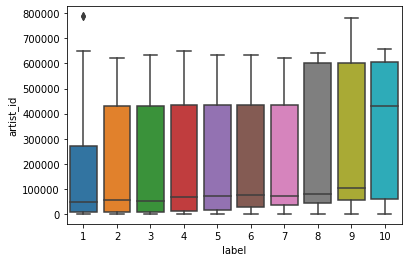

In [43]:
a = train_info_rank[['label', 'artist_id']].loc[train_info_rank.n_artist_names == 1].astype(int)
sns.boxplot(data=a, x='label', y='artist_id')

In [44]:
train_info_rank[train_info_rank.label == 1]

ID                                              title  \
14    1074247432                                  Tình Nhỏ Mau Quên   
28    1075033645                                            Một Nhà   
56    1075810266   Trở Về Đi (Tỉnh Giấc Tôi Thấy Mình Trong Ai OST)   
64    1075810346                                  Con Đê Chung Tình   
69    1075810351                                       LK Duy Khánh   
94    1075810896                                Người Ta Thuờng Nói   
106   1075810944                                         Phải Có Em   
136   1075811092                                           Ðính Ước   
141   1075811101                                 Tình Nghèo Có Nhau   
162   1075811225                            Xin Em Đừng Khóc Vu Quy   
163   1075811227                                         Hận Tha La   
164   1075811228                                          Đêm Bơ Vơ   
165   1075811229                         Tình Em Biển Rộng Sông Dài   
175   1075811259                                  Cô Đơn Mới Tìm Em   
176   1075811260                                     Yêu Anh Là Sai   
179   1075811265                        Cảm Ơn (We Belong Together)   
180   1075811266                                  Sẽ Không Dừng Lại   
233   1075811432                                  Vì Anh Là Soái Ca   
283   1075811698                                  Trái Tim Vàng Son   
290   1075834004                                Câu Chuyện Làm Quen   
291   1075834188                                   I Need Your Love   
293   1075834917                                          We Hear U   
304   1075835218                                            Tỏ Tình   
311   1075835464  Mashup Các Bài Hát Hay Nhất 2016 – Mashup Vpop...   
319   1075836072                                              Em Ơi   
323   1075837095                                      Em Bận Cô Đơn   
332   1075837155                       Đợi Anh Đợi Đến Hoa Cũng Tàn   
334   1075837159                                          Anh Sẽ Về   
335   1075838024                                Mai Này Nếu Như Anh   
341   1075874007                     Tình Yêu Không Thể Từ Một Phía   
...          ...                                                ...   
8882  1078414799                                     Anh Đâu Có Hay   
8898  1078424448                              Chỉ Còn Trong Nỗi Nhớ   
8901  1078428747                 Vô Cùng (Vì Anh Thương Em) (Remix)   
8927  1078441780                                   Hôm Nay Chia Tay   
8964  1078448800              Lời Xin Lỗi Cuối Cùng (Kiếp Cần Sa 2)   
8965  1078448888                                      Bay Lên Em Ei   
8968  1078450911                                        Lạc Mất Anh   
8969  1078451265                                  Rapper Thị Trường   
8970  1078451376                                Rồi Sẽ Có Một Người   
8979  1078461685             Có Một Ngày Mưa Như Thế (Duet Version)   
8990  1078476165     Chia Tay Đâu Phải Là Kết Thúc (Ballad Version)   
8997  1078477635                                   Người Con Gái Ấy   
9002  1078478143                                  Lắng Nghe Nỗi Nhớ   
9006  1078478402                                   Chuyện Cũ Bỏ Qua   
9009  1078478765                                   Đi Tìm Người Yêu   
9010  1078478821                                     Ai Nói Ai Nghe   
9011  1078478838                             Yêu Nhau Yêu Nhau Thôi   
9021  1078478993                                     Tất Cả Tại Anh   
9046  1078487553                                             Hạ Tan   
9048  1078492734               Sẽ Hứa Đi Cùng Nhau (Đi Để Trở Về 3)   
9050  1078493408  Mashup Cần Lắm Đấy - Anh Đang Ở Đâu Đấy Anh - ...   
9055  1078494921                         Đừng Như Thói Quen (Remix)   
9056  1078495216                              Chúng Ta Từng Rất Đẹp   
9058  1078495239                                             Please   
9060  1078495263                      

In [45]:
train_info_rank[train_info_rank.artist_name == 'Chi Pu']

ID                                             title  \
56    1075810266  Trở Về Đi (Tỉnh Giấc Tôi Thấy Mình Trong Ai OST)   
1599  1076403171                        Từ Hôm Nay (Feel Like Ooh)   
1932  1076419881               Cho Ta Gần Hơn (I'm In Love) (Beat)   
1933  1076419882                      Cho Ta Gần Hơn (I'm In Love)   
2273  1076444419           Cho Ta Gần Hơn (I'm In Love) (Acoustic)   
2359  1076447330               Em Sai Rồi Anh Xin Lỗi Em Đi (Beat)   
2660  1078004601                     Talk To Me (Có Nên Dừng Lại?)   
2682  1078005834              Talk To Me (Có Nên Dừng Lại?) (Beat)   
3520  1078036024                                       Tôi Vẫn Hát   

     artist_name artist_id           composers_name   composers_id  \
56        Chi Pu     32775          Phạm Toàn Thắng           7328   
1599      Chi Pu     32775  Krazy Park, Eddy S Park  432554.432555   
1932      Chi Pu     32775  Krazy Park, Eddy S Park  432554.432555   
1933      Chi Pu     32775  Krazy Park, Eddy S Park  432554.432555   
2273      Chi Pu     32775  Krazy Park, Eddy S Park  432554.432555   
2359      Chi Pu     32775               Trang Pháp         101888   
2660      Chi Pu     32775            Triple D (3D)          14851   
2682      Chi Pu     32775            Triple D (3D)          14851   
3520      Chi Pu     32775                   Andiez          13058   

             release_time  label    version   isV1  ... recording_date  \
56    2017-09-01 16:15:00      1  (2, 3, 0)  False  ...            NaN   
1599  2017-10-10 18:51:00      1  (2, 3, 0)  False  ...         2017.0   
1932  2017-10-27 17:14:00      2  (2, 3, 0)  False  ...         2017.0   
1933  2017-10-27 17:14:00      1  (2, 3, 0)  False  ...         2017.0   
2273  2017-11-23 23:42:00      2  (2, 3, 0)  False  ...         2017.0   
2359  2017-11-28 16:10:00      1  (2, 3, 0)  False  ...         2017.0   
2660  2017-12-21 23:33:00      1  (2, 3, 0)  False  ...         2017.0   
2682  2017-12-24 01:49:00      2  (2, 3, 0)  False  ...         2017.0   
3520  2018-01-26 23:27:00      2  (2, 3, 0)  False  ...         2018.0   

     tagging_date      disc_num non_std_genre  \
56            NaN  (None, None)      Nhạc Trẻ   
1599          NaN  (None, None)      Nhạc Trẻ   
1932          NaN  (None, None)      Nhạc Trẻ   
1933          NaN  (None, None)      Nhạc Trẻ   
2273          NaN  (None, None)      Nhạc Trẻ   
2359          NaN  (None, None)      Nhạc Trẻ   
2660          NaN  (None, None)      Nhạc Trẻ   
2682          NaN  (None, None)      Nhạc Trẻ   
3520          NaN  (None, None)      Nhạc Trẻ   

                                      user_text_frames       artist_origin  \
56    mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
1599  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
1932  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
1933  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
2273  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
2359  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
2660  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
2682  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
3520  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   

     n_artist_ids  n_artist_names n_composer_ids  n_composer_names  
56              1               1              1                 1  
1599            1               1              2                 2  
1932            1               1              2                 2  
1933            1               1              2                 2  
2273            1               1              2                 2  
2359            1               1              1                 1  
2660            1               1              1                 1  
2682            1               1              

In [46]:
train_info_rank[train_info_rank.artist_name == 'Da LAB']

ID          title artist_name artist_id composers_name  \
28    1075033645        Một Nhà      Da LAB     56067         Da Lab   
797   1076341408            Còi      Da LAB     56067         Da Lab   
2213  1076441808            Già      Da LAB     56067         Da Lab   
6860  1078193485  Cùng Nhịp Đập      Da LAB     56067         Da LAB   
7173  1078205744     Thanh Xuân      Da LAB     56067         Da LAB   

     composers_id         release_time  label    version   isV1  ...  \
28         104359  2017-09-25 17:02:00      1  (2, 3, 0)  False  ...   
797        104359  2017-09-08 19:04:00      2  (2, 3, 0)  False  ...   
2213       104359  2017-11-20 23:31:00      1  (2, 3, 0)  False  ...   
6860        56067  2018-09-09 00:37:00      2  (2, 3, 0)  False  ...   
7173        56067  2018-08-25 00:04:00      1  (2, 3, 0)  False  ...   

     recording_date tagging_date      disc_num non_std_genre  \
28              NaN          NaN  (None, None)      Nhạc Trẻ   
797          2017.0          NaN  (None, None)      Nhạc Trẻ   
2213         2017.0          NaN  (None, None)      Nhạc Trẻ   
6860            NaN          NaN  (None, None)      Nhạc Trẻ   
7173         2018.0          NaN  (None, None)      Nhạc Trẻ   

                                      user_text_frames       artist_origin  \
28    mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
797   mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
2213  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
6860  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
7173  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   

     n_artist_ids  n_artist_names n_composer_ids  n_composer_names  
28              1               1              1                 1  
797             1               1              1                 1  
2213            1               1              1                 1  
6860            1               1              1                 1  
7173            1               1              1                 1  

[5 rows x 39 columns]

In [47]:
train_info_rank[train_info_rank.artist_name == 'Quang Lê, Hương Thủy']

ID              title           artist_name artist_id  \
14  1074247432  Tình Nhỏ Mau Quên  Quang Lê, Hương Thủy    828.87   

   composers_name composers_id         release_time  label    version   isV1  \
14       Hàn Châu       100406  2017-10-01 22:32:00      1  (2, 3, 0)  False   

    ... recording_date tagging_date      disc_num  non_std_genre  \
14  ...            NaN          NaN  (None, None)  Nhạc Trữ Tình   

                                    user_text_frames       artist_origin  \
14  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   

   n_artist_ids  n_artist_names n_composer_ids  n_composer_names  
14            2               2              1                 1  

[1 rows x 39 columns]

In [48]:
train_info_rank[train_info_rank.artist_name == 'Quang Lê']

ID                       title artist_name artist_id  \
162   1075811225     Xin Em Đừng Khóc Vu Quy    Quang Lê       828   
163   1075811227                  Hận Tha La    Quang Lê       828   
165   1075811229  Tình Em Biển Rộng Sông Dài    Quang Lê       828   
166   1075811231          Vùng Quê Tương Lai    Quang Lê       828   
167   1075811234        Xin Đừng Trách Đa Đa    Quang Lê       828   
231   1075811401          Đường Về Quê Hương    Quang Lê       828   
3377  1078030976          Áo Cưới Màu Hoa Cà    Quang Lê       828   

     composers_name composers_id         release_time  label    version  \
162     Minh Phương         9183  2017-10-01 22:32:00      1  (2, 3, 0)   
163        Sơn Thảo       102453  2017-10-01 22:32:00      1  (2, 3, 0)   
165       Thông Đạt       100022  2017-10-01 22:32:00      1  (2, 3, 0)   
166       Duy Khánh        10718  2017-10-01 22:32:00      7  (2, 3, 0)   
167    Võ Đông Điền       100136  2017-10-01 22:32:00      2  (2, 3, 0)   
231      Lam Phương       100043  2017-11-01 19:00:00      8  (2, 3, 0)   
3377      Hùng Linh       101600  2018-01-22 00:45:00      1  (2, 3, 0)   

       isV1  ... recording_date tagging_date      disc_num  non_std_genre  \
162   False  ...            NaN          NaN  (None, None)  Nhạc Trữ Tình   
163   False  ...            NaN          NaN  (None, None)  Nhạc Trữ Tình   
165   False  ...            NaN          NaN  (None, None)  Nhạc Trữ Tình   
166   False  ...            NaN          NaN  (None, None)  Nhạc Trữ Tình   
167   False  ...            NaN          NaN  (None, None)  Nhạc Trữ Tình   
231   False  ...            NaN          NaN  (None, None)       Nhạc Trẻ   
3377  False  ...         2011.0          NaN  (None, None)  Nhạc Trữ Tình   

                                      user_text_frames       artist_origin  \
162   mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
163   mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
165   mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
166   mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
167   mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
231   mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
3377  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   

     n_artist_ids  n_artist_names n_composer_ids  n_composer_names  
162             1               1              1                 1  
163             1               1              1                 1  
165             1               1              1                 1  
166             1               1              1                 1  
167             1               1              1                 1  
231             1               1              1                 1  
3377            1               1              1                 1  

[7 rows x 39 columns]

### Check the intersection of values in each column of train_info and test_info

In [49]:
set(train_info.ID).intersection(set(test_info.ID))

set()

- No intersection of ID column between train_info and test_info

In [50]:
def count_intersection(col_name):
    print('Number of mutual values between train_info %s column and test_info %s column:'%(col_name, col_name))
    print(len(set(train_info[col_name]).intersection(set(test_info[col_name]))))

In [51]:
print('Number of unique artist_id in train_set:', len(train_info_rank.artist_id.unique()))
print('Number of unique artist_id in test_set:', len(test_info.artist_id.unique()))

print('Number of unique artist_name in train_set:', len(train_info_rank.artist_name.unique()))
print('Number of unique artist_name in test_set:', len(test_info.artist_name.unique()))

Number of unique artist_id in train_set: 2391
Number of unique artist_id in test_set: 675
Number of unique artist_name in train_set: 2397
Number of unique artist_name in test_set: 677


In [52]:
count_intersection('artist_id')
count_intersection('artist_name')
count_intersection('composers_id')
count_intersection('composers_name')

Number of mutual values between train_info artist_id column and test_info artist_id column:
519
Number of mutual values between train_info artist_name column and test_info artist_name column:
519
Number of mutual values between train_info composers_id column and test_info composers_id column:
484
Number of mutual values between train_info composers_name column and test_info composers_name column:
467


In [53]:
### Map artists'id with their name
id_name_dict = None

id_names_unique = train_info_rank.loc[train_info_rank.n_artist_names == 1, ['artist_id', 'artist_name']].drop_duplicates()

In [54]:
# id_names_unique['artist_id'].value_counts()

In [55]:
id_names_unique[id_names_unique.artist_id == '47562']

artist_id artist_name
1387     47562         BAK
5367     47562     Bảo Kun

In [56]:
# id_names_unique.artist_id.value_counts()

- There maybe multiple artist names with the same artist ids, but those names actually belong to 1 artist

In [57]:
# train_info_rank.groupby(['artist_id', 'label'])['label'].count()

In [58]:
# song_count_each_rank = pd.pivot_table(train_info_rank, index='artist_id', columns='label', values='artist_name', aggfunc='count').fillna(0)

In [59]:
# song_count_each_rank.head()

### n_months_counts:
count number of month from released time to now

In [60]:
def months_between(date1,date2):
    if date1>date2:
        date1,date2=date2,date1
    m1=date1.year*12+date1.month
    m2=date2.year*12+date2.month
    months=m2-m1
    if date1.day>date2.day:
        months-=1
    elif date1.day==date2.day:
        seconds1=date1.hour*3600+date1.minute+date1.second
        seconds2=date2.hour*3600+date2.minute+date2.second
        if seconds1>seconds2:
            months-=1
    return months

In [61]:
months_between(datetime.datetime.now(), pd.to_datetime(train_info_rank.release_time).iloc[4])

23

In [62]:
train_info_rank['release_time'] = pd.to_datetime(train_info_rank.release_time)
last_date = train_info_rank['release_time'].max()
print(last_date)
# train_info_rank['n_month_counts'] = train_info_rank.release_time - last_date
train_info_rank['n_month_counts'] = train_info_rank.release_time.map(lambda x: months_between(last_date, x))

2018-12-31 22:32:00


In [63]:
train_info_rank['n_month_counts'] = train_info_rank.release_time.map(lambda x: months_between(last_date, x))

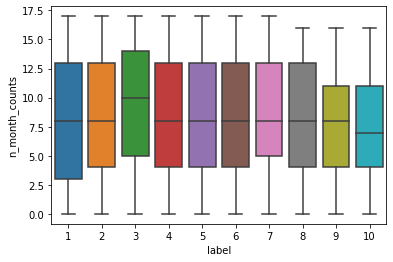

In [64]:
sns.boxplot(data=train_info_rank, x='label', y='n_month_counts')

In [65]:
train_info_rank.groupby('artist_id')['label'].agg(lambda x: len(x.unique())).value_counts()

1    1318
2     487
3     228
4     154
5      93
6      56
7      31
8      17
9       7
Name: label, dtype: int64

In [66]:
train_info_rank.groupby('artist_id')['label'].agg(lambda x: len(x.unique()))

artist_id
100158                1
10037                 1
100811.12693          1
101026                1
10119                 1
101893                1
1019                  1
102044                1
10210                 2
102217.832            1
1023                  1
10237                 1
1024.899              1
102693.67183          1
10343                 5
10343.613247          1
10348                 2
103597.432565         1
103597.604844         1
103679                1
103705                3
103705.600472         1
103705.600473         1
10431.173             2
104338                1
104447                2
10482                 3
105017                1
105038.189627         2
105052                4
                     ..
9145.9045             1
9145.9839             1
918                   1
9189                  1
9204                  1
9204.65914            1
9209                  1
923                   1
9241                  2
9253                  1
931   

In [67]:
train_info_rank[train_info_rank.artist_id == '105052']

ID                      title artist_name artist_id  \
6786  1078188633       Anh Còn Nhớ Em Không     Linh Na    105052   
7801  1078236710    Gặp Lại Chỉ Là Người Lạ     Linh Na    105052   
8099  1078247340  Học Thùy Mị Nết Na (Beat)     Linh Na    105052   
8100  1078247341         Học Thùy Mị Nết Na     Linh Na    105052   

           composers_name composers_id        release_time  label    version  \
6786         Cao Tùng Anh       101343 2018-03-08 22:37:00      9  (2, 3, 0)   
7801  Nhạc Ngoại Lời Việt       100103 2018-02-10 22:54:00     10  (2, 3, 0)   
8099         Cao Tùng Anh       101343 2018-11-10 17:33:00      8  (2, 3, 0)   
8100         Cao Tùng Anh       101343 2018-11-10 17:33:00      6  (2, 3, 0)   

       isV1  ... tagging_date      disc_num non_std_genre  \
6786  False  ...          NaN  (None, None)      Nhạc Trẻ   
7801  False  ...          NaN  (None, None)      Nhạc Trẻ   
8099  False  ...          NaN  (None, None)      Nhạc Trẻ   
8100  False  ...          NaN  (None, None)      Nhạc Trẻ   

                                      user_text_frames       artist_origin  \
6786  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
7801  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
8099  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   
8100  mp3.zing.vn Zing MP3 Zing MP3 - Đỉnh cao âm nhạc  [None, None, None]   

     n_artist_ids n_artist_names  n_composer_ids n_composer_names  \
6786            1              1               1                1   
7801            1              1               1                1   
8099            1              1               1                1   
8100            1              1               1                1   

      n_month_counts  
6786               9  
7801              10  
8099               1  
8100               1  

[4 rows x 40 columns]

In [68]:
del train_info_rank['n_month_counts']

In [69]:
train_info_rank[train_info_rank.title.map(lambda x: '' in x.lower())]['label'].value_counts()

10    932
6     920
1     916
7     913
3     910
9     909
2     905
8     902
4     895
5     876
Name: label, dtype: int64

In [70]:
all_titles = pd.concat([train_info_rank.title, test_info.title])
import re
ptn = re.compile(r'[ ./()]')
title_word = pd.Series(re.split(ptn, all_titles.str.lower().str.cat(sep=' ')))

In [71]:
ten_mode_words = title_word[title_word != ''].value_counts().index.values[:8]
ten_mode_words

array(['em', 'tình', 'beat', 'anh', 'yêu', 'người', 'remix', 'xuân'],
      dtype=object)

In [72]:
ten_least_words = title_word[title_word != ''].value_counts().index.values[-200:]
ten_least_words

array(['rising', 'thắp', 'hân', 'siro', 'us', 'tho', 'nhiếp', 'thổi',
       'giăng', 'vú', 'khuyến', 'pako', 'loi', 'vong', 'binh', 'đu',
       'ơi…', 'cậy', 'ocean', 'krazy', 'mimosa', 'rong', 'close', 'sành',
       'miracle', 'monalisa', 'and', 'tham', 'thâu', 'hand', 'dreams',
       'khởi', 'sea', 'max', 'parody', 'nothing', 'oai', 'xong', "80's",
       'dưỡng', 'khỏi', 'de', 'hí', 'nan', 'latin', 'mua', 'xiêu',
       'mashup:', 'moon', 'want', 'd', 'trùm', 'what', 'tú', 'thỉ',
       'asia', 'high', 'xấu', 'úng', "you'll", 'trâu', 'ariang', 'ưu',
       'đáp', 'sluông', 'sơmi', 'mỏng', 'miễn', 'vóc', 'cạm', 'đứt',
       'gói', 'top', 'quật', 'mine', 'family', 'thúy', 'chài', 'mạn',
       'forest', 'soul', 'siết', 'cọp', 'came', 'stay', 'idol', 'liều',
       'pom&why', 'mía', 'em,tôi', 'ngưỡng', 'sậu', 'đây?', 'thiện',
       'hdor', 'hót', 'gởi', 'yang', 'còi', 'thưởng', 'kings', 'hài',
       'stars', 'fire', 'tara', 'máu', 'vằn', 'quỷ', 'khứ,', 'nhoi',
       'uông', 'dr

In [73]:
# title_word.value_counts()

In [74]:
for word in ten_mode_words:
    train_info_rank[word] = train_info_rank.title.map(lambda x: word in x.lower()).astype(int)
    test_info[word] = test_info.title.map(lambda x: word in x.lower()).astype(int)


In [75]:
train_info_rank['contain_rare_word'] = train_info_rank.title.map(lambda x: pd.Series(re.split(ptn, x.lower())).isin(ten_least_words).sum())

In [76]:
train_info_rank['contain_rare_word'].sum()

179

In [77]:
# test_info.head()

In [78]:
# train_info_rank['title_count'] = train_info_rank.title.map(lambda x: len(x.split(' ')))

In [79]:
title_count = all_titles.value_counts().reset_index()
title_count

index  title
0                              Đắp Mộ Cuộc Tình     35
1                             Lại Nhớ Người Yêu     33
2                                    Đoạn Tuyệt     32
3                           Con Đường Xưa Em Đi     27
4                              Cát Bụi Cuộc Đời     25
5                                    Đêm Tâm Sự     22
6                            Câu Chuyện Đầu Năm     21
7                          Người Tình Không Đến     19
8                                 Hoa Nở Về Đêm     18
9                                    Duyên Phận     17
10                               Vùng Lá Me Bay     15
11                        Sương Lạnh Chiều Đông     15
12                                 Hoa Trinh Nữ     15
13                                      Phố Đêm     14
14                             Nối Lại Tình Xưa     14
15                              Mùa Xuân Xa Quê     14
16                                 Hãy Quên Anh     14
17                           Chuyến Đò Không Em     13
18                    Chuyện Tình Không Dĩ Vãng     13
19                              Cho Vừa Lòng Em     13
20                               Thành Phố Buồn     13
21                                    Ngày Buồn     12
22                                 Yêu Một Mình     12
23                                      Cõi Nhớ     12
24                                           Mẹ     12
25                                       Mẹ Tôi     12
26                         Chuyến Tàu Hoàng Hôn     12
27                                Nhớ Nhau Hoài     12
28                                Vu Lan Nhớ Mẹ     12
29                      Nếu Được Làm Người Tình     12
...                                         ...    ...
7455                   Anh Chẳng Sao Mà (Remix)      1
7456                                    Lá Xanh      1
7457                Đã Mất (EDM Version) (Beat)      1
7458                                    Còn Anh      1
7459                       Chẳng Ai Thương Mình      1
7460               Hai Ta Đều Tổn Thương (Beat)      1
7461                                     Origin      1
7462                        Hà Nội Ngày Chia Xa      1
7463                          Om Mani Padme Hum      1
7464                              Khua Yang Kao      1
7465                       Anh Có Nhớ Em Không?      1
7466                           Tình Anh Dại Khờ      1
7467                  Best Friend (Tao Với Mày)      1
7468                Mong Em Hạnh Phúc Bên Người      1
7469     Liên Khúc Mùa Xuân Sang Có Hoa Anh Đào      1
7470       Nếu Có Một Khoảng Cách (BeeBB Remix)      1
7471                          Tết Trên Bản Làng      1
7472              Chia Đôi Một Trái Tim (Remix)      1
7473                                     Là Khi      1
7474                      Ngày Mùa Xuân Vừa Ghé      1
7475  Anh Không Thể Quên (i won't for get baby)      1
7476                              Đâu Cũng Được      1
7477                              Ngày Đó Có Em      1
7478     Những Dấu Yêu Ngọt Ngào (Remix) (Beat)      1
7479          Cánh Thiệp Đầu Xuân (New Version)      1
7480                          Em Hỡi Anh Về Đây      1
7481                                   Hoài Cảm      1
7482                   Mưa Chiều Kỷ Niệm (Beat)      1
7483                                     Hè Vội      1
7484                  Đi Tiếp Nhé, Việt Nam Ơi!      1

[7485 rows x 2 columns]

In [80]:
train_info_rank = pd.merge(left=train_info_rank, right=title_count, left_on='title', right_on='index', how='inner').drop(['index', 'title_x'], axis=1)
test_info = pd.merge(left=test_info, right=title_count, left_on='title', right_on='index', how='inner').drop(['index', 'title_x'], axis=1)

In [81]:
train_info_rank.head()

ID  artist_name artist_id composers_name composers_id  \
0  1073748245    Như Quỳnh       551   Châu Đình An         5765   
1  1073751978   Minh Tuyết       455      Trường Sa       100105   
2  1076456879  Quang Thắng    432303      Trường Sa       100105   
3  1073835561     Lưu Bích       450       Quốc Bảo         4355   
4  1073856553    Như Quỳnh       551        Bắc Sơn         7686   

         release_time  label    version   isV1  isV2  ... em tình beat anh  \
0 2017-10-01 22:07:00      7  (2, 3, 0)  False  True  ...  0    0    0   0   
1 2017-10-01 20:58:00      3  (2, 3, 0)  False  True  ...  0    0    0   0   
2 2017-08-13 01:30:00      9  (2, 3, 0)  False  True  ...  0    0    0   0   
3 2017-11-01 18:16:00      6  (2, 3, 0)  False  True  ...  0    0    0   0   
4 2017-11-01 17:36:00      2  (2, 3, 0)  False  True  ...  0    0    0   0   

  yêu người  remix xuân  contain_rare_word  title_y  
0   0     0      0    0                  0        1  
1   0     0      0    0                  0        2  
2   0     0      0    0                  0        2  
3   0     0      0    0                  0        1  
4   0     0      0    0                  0        8  

[5 rows x 48 columns]

In [82]:
test_info.head()

ID         artist_name  artist_id composers_name composers_id  \
0  1073994292          Minh Tuyết        455        Minh Vy       100019   
1  1074250503            Tâm Đoan        518      Nhật Ngân       100218   
2  1074254709  Hùng Phú, Duy Linh  18241.918       Huy Liêu       430572   
3  1074254735         Xuân Trường      11740       Huy Liêu       430572   
4  1074326411            Quang Lê        828      Song Ngọc       100288   

          release_time    version   isV1  isV2              artist  ...  \
0  2017-11-01 18:27:00  (2, 3, 0)  False  True          Minh Tuyết  ...   
1  2017-10-01 22:07:00  (2, 3, 0)  False  True            Tâm Đoan  ...   
2  2017-11-07 23:47:00  (2, 3, 0)  False  True  Hùng Phú, Duy Linh  ...   
3  2017-11-07 23:38:00  (2, 3, 0)  False  True         Xuân Trường  ...   
4  2017-10-01 21:33:00  (2, 3, 0)  False  True            Quang Lê  ...   

  n_composer_names em tình beat anh  yêu người  remix  xuân  title_y  
0                1  1    0    0   0    0     0      0     0        1  
1                1  0    0    0   0    0     0      0     0        1  
2                1  0    0    0   0    0     0      0     0        1  
3                1  0    0    0   0    0     0      0     0        1  
4                1  0    0    0   0    0     0      0     0       10  

[5 rows x 46 columns]

In [83]:
# train_info_rank['title_count'] = train_info_rank.title.map(lambda x: len(x.split(' ')))

In [84]:
# sns.boxplot(data=train_info_rank, x='label', y='tsitle_count')

### lyrics

In [85]:
train_info_rank[~train_info_rank.lyrics.isnull()]['lyrics']

0       Đêm nay anh gánh dầu ra biển anh chôn \r\nAnh ...
1       Chiều mưa không có em\r\nbờ đá công viên âm th...
3       Rồi ánh trăng cũng đang tan dần\r\nRồi ước mơ ...
4       Nắng hạ đi Mây trôi lang thang cho hạ buồn Coi...
12      Ai trong tình yêu, ai không mơ mộng?\n\nNgu ng...
13      Đã từ lâu tôi vẫn thường trong bóng đêm\r\nMan...
14      Những đêm buồn nghe mưa ngoài hiên mưa triền m...
16      Em có biết từ khi em ra đi trong lòng anh cả 1...
17      Một người buồn lắm, đêm nằm mơ người xưa ghé t...
18      Còn bao nhiêu giấc mơ ta vẫn mơ về\r\nCòn bao ...
20      Rồi mai tôi đưa em xa kỷ niệm.\r\nXin lời cuối...
23      Rồi cũng đến lúc\nNgười cũng muốn quên ta rồi\...
24      Người đã bỏ em đi theo ai\nTrong em chữ yêu đã...
25      Hôm nao hoa phượng nở\nvề quê ghé thăm nhà em\...
26      Hôm nao hoa phượng nở về quê ghé thăm nhà em. ...
33      Bao xa hoa đam mê vây lấy em \r\nAnh ta mang đ...
34      Từng ngày trôi qua từng ngày thật buồn \r\nMột...
35      Một th

# 2. Training

In [86]:
def split_time(raw_time_col):
    time_col = pd.to_datetime(raw_time_col)
    return time_col.dt.year, time_col.dt.month, time_col.dt.day, time_col.dt.hour

def label_encode_column(train_df, val_df, test_df, col_name):
    '''Return encoder, transformed train column, test column'''
    data = pd.concat([train_df[col_name], val_df[col_name], test_df[col_name]])
    label_encoder = LabelEncoder()
    label_encoder.fit(data)
    return (label_encoder, 
            label_encoder.transform(train_df[col_name]), 
            label_encoder.transform(val_df[col_name]),
            label_encoder.transform(test_df[col_name]))

def mse(model, X, y):
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

In [168]:
np.random.seed(111)
def split_train_val(df, test_size=0.3, random_state=123):
    n = int(len(df)*test_size)
    test_indices = np.random.choice(df.index.values, n, replace=False)
    return df.drop(test_indices, axis=0), df.iloc[test_indices]

cate_col = ['artist_id', 'artist_name', 'genre']
train_info_rank[cate_col] = train_info_rank[cate_col].fillna('Missing')
test_info[cate_col] = test_info[cate_col].fillna('Missing')

# numeric_col = ['best_release_date']
# train_info_rank[numeric_col] = train_info_rank[numeric_col].fillna(0)
# test_info[numeric_col] = test_info[numeric_col].fillna(0)
    
data_train_val = train_info_rank.copy()
data_test = test_info.copy()

data_train, data_val = split_train_val(data_train_val)
# song_count_each_rank = pd.pivot_table(data_train, index='artist_id', columns='label', values='artist_name', aggfunc='count').fillna(0)

rank_cols = [str(i) for i in range(1,11)]

for col in cate_col:
    _, train_col, val_col, test_col = label_encode_column(data_train, data_val, data_test, col)
    data_train[col] = train_col
    data_val[col] = val_col
    data_test[col] = test_col

for df in [data_train, data_val, data_test]:
    year, month, day, hour = split_time(df['release_time'])
    df['year'] = year
    df['month'] = month 
    df['day'] = day
    df['hour'] = hour
    
# Drop redundant columns
# col_to_drops = ['ID', 'release_time', 'composers_name', 'composers_id', 'n_composer_names', 'n_composer_ids']
# for df in [data_train, data_val, data_test]:
#     df.drop(col_to_drops, axis=1, inplace=True)
col_to_keeps = ['artist_name', 'artist_id', 'n_artist_ids', 'n_artist_names',
               'title_y','year', 'month', 'day', 'hour', 'genre'] + ten_mode_words.tolist()

data_train = data_train[col_to_keeps+['label']]
data_val = data_val[col_to_keeps+['label']]
data_test = data_test[col_to_keeps]

/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [169]:
data_test[col_to_keeps]

artist_name  artist_id  n_artist_ids  n_artist_names  title_y  year  \
0            1283       1162             1               1        1  2017   
1            2142       1235             1               1        1  2017   
2             658        329             2               2        1  2017   
3            2348        150             1               1        1  2017   
4            1659       2430             1               1       10  2017   
5            1242        681             2               2       10  2017   
6            2134       2067             2               2       10  2018   
7            1129       1153             1               1        1  2017   
8            1826       1206             1               1        1  2017   
9             663       2333             1               1        4  2017   
10           1395       2353             1               1        2  2017   
11           2533        269             1               1        1  2017   
12           1886       1255             1               1        1  2017   
13           2139       2258             1               1        1  2017   
14            117        351             1               1        1  2017   
15           1417        551             1               1        1  2017   
16           1100        127             1               1        1  2017   
17           1027       2406             1               1        2  2017   
18           1027       2406             1               1        1  2017   
19           1603        698             1               1        2  2017   
20           1308       2508             3               3        1  2017   
21           1590        761             2               2        1  2017   
22            238       1196             2               2        1  2017   
23            252        314             3               3        2  2017   
24           1589        760             1               1        2  2017   
25           2391       1336             1               1        6  2017   
26            522       1448             1               1        6  2018   
27           1942        346             1               1        1  2017   
28           1942        346             1               1        5  2017   
29           1942        346             1               1        1  2017   
...           ...        ...           ...             ...      ...   ...   
1088         1246       2422             1               1        1  2018   
1089         2467        284             1               1        1  2018   
1090         1032        102             1               1        1  2018   
1091          291        500             1               1        1  2018   
1092          704       1977             1               1        1  2018   
1093         1542       1610             2               2        1  2018   
1094         1865       2483             1               1        1  2018   
1095           50        821             1               1        3  2018   
1096         1906       1405             1               1        1  2018   
1097         1865       2483             1               1        1  2018   
1098         1869       2488             2               2        2  2018   
1099         1865       2483             1               1        1  2018   
1100         1869       2488             2               2        1  2018   
1101         1869       2488             2               2        1  2018   
1102         1868       2489             2               2        1  2018   
1103         1865       2483             1               1        1  2018   
1104          355       2450             1               1        1  2018   
1105          720         37             1               1        1  2018   
1106         2032       1990             1               1        1  2018   
1107          385       1815             1               1        1  2018   
11

In [170]:
X_train, y_train = data_train.drop('label', axis=1), data_train['label']
X_val, y_val = data_val.drop('label', axis=1), data_val['label']


In [171]:
data_train.head()

artist_name  artist_id  n_artist_ids  n_artist_names  title_y  year  month  \
0         1496       1304             1               1        1  2017     10   
1         1283       1162             1               1        2  2017     10   
3         1129       1153             1               1        1  2017     11   
7          528       2155             1               1        8  2018      8   
8         1303       1390             1               1        8  2018     12   

   day  hour  genre  em  tình  beat  anh  yêu  người  remix  xuân  label  
0    1    22     11   0     0     0    0    0      0      0     0      7  
1    1    20     11   0     0     0    0    0      0      0     0      3  
3    1    18      9   0     0     0    0    0      0      0     0      6  
7    2     2     11   0     0     0    0    0      0      0     0      8  
8    1    17     11   0     0     0    0    0      0      0     0      9

In [172]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=10, learning_rate=0.1, reg_lambda=3, reg_alpha=1.5)
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)


In [173]:
xgb_model.fit(X_train, y_train)

/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=1.5, reg_lambda=3, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [174]:
mse(xgb_model, X_train, y_train)

0.9748382120369185

In [175]:
mse(xgb_model, X_val, y_val)

3.3402081687242484

In [176]:
voter = VotingRegressor([('xgb',xgb_model), ('rf', rf)], weights=[0.9, 0.4])
voter.fit(X_train, y_train)

/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=10, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_alpha=1.5,
                                          reg_...
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                  

In [177]:
mse(voter, X_train, y_train)

0.8151844908421214

In [178]:
mse(voter, X_val, y_val)

3.332665580023002

In [98]:
voter.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

/home/nam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=10, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_alpha=1.5,
                                          reg_...
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                  

In [99]:
y_test_pred = voter.predict(data_test)
y_test_pred = np.clip(y_test_pred, a_min=0, a_max=10)

In [100]:
# data_test.head()

In [101]:
sample_submission = pd.read_csv('sample_submission.csv', names=['ID', 'label'])
sample_submission.head()
submission = sample_submission.copy()
submission['ID'] = test_info.ID
submission['label'] = y_test_pred

In [102]:
submission.to_csv('submission.csv', header=False, index=False)

In [103]:
# special multiple name ?